In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Aug 18 13:00:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 13.6 gigabytes of available RAM



In [ ]:
!rm -rf AML
!git clone https://github.com/gianpd/AML.git
!pip install -q scikit-plot

Cloning into 'AML'...
remote: Enumerating objects: 183, done.
remote: Counting objects: 100% (183/183), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 183 (delta 106), reused 123 (delta 54), pack-reused 0
Receiving objects: 100% (183/183), 50.00 KiB | 10.00 MiB/s, done.
Resolving deltas: 100% (106/106), done.


# Elliptic Exploration



### Download Elliptic Dataset from Kaggle repository

In [ ]:
!pip install -q kaggle

In [ ]:
# import kaggle credentials
from google.colab import files
_ = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
import os
import json

with open('kaggle.json') as f:
  kaggle_creds = json.load(f)

os.environ['KAGGLE_USERNAME'] = kaggle_creds['username']
os.environ['KAGGLE_KEY'] = kaggle_creds['key']

In [ ]:
!kaggle datasets download -d ellipticco/elliptic-data-set
!mkdir data
!unzip elliptic-data-set.zip -d data/

 99% 145M/146M [00:01<00:00, 160MB/s]
100% 146M/146M [00:01<00:00, 146MB/s]
Archive:  elliptic-data-set.zip
  inflating: data/elliptic_bitcoin_dataset/elliptic_txs_classes.csv  
  inflating: data/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv  
  inflating: data/elliptic_bitcoin_dataset/elliptic_txs_features.csv  


In [ ]:
import os
import sys
import pathlib

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

# supervised baseline
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# visualization
import scikitplot as skplt


# feature/model selection
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, SelectFromModel
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV

# # evaluation
# from sklearn.metrics import classification_report
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import precision_recall_curve, average_precision_score, precision_recall_fscore_support

import logging
logging.basicConfig(stream=sys.stdout, format='',
                level=logging.INFO, datefmt=None)
logger = logging.getLogger('elliptic_exploration')

from IPython.display import display, Markdown, HTML, Image

from AML.utils import *

In [ ]:
DATASET_PATH = '/content/data/elliptic_bitcoin_dataset'
df_classes, df_edge, df_features = import_elliptic_data_from_csvs(DATASET_PATH)

In [ ]:
df_classes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203769 entries, 0 to 203768
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   txId    203769 non-null  int64 
 1   class   203769 non-null  object
dtypes: int64(1), object(1)
memory usage: 3.1+ MB


In [ ]:
df_edge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234355 entries, 0 to 234354
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   txId1   234355 non-null  int64
 1   txId2   234355 non-null  int64
dtypes: int64(2)
memory usage: 3.6 MB


In [ ]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203769 entries, 0 to 203768
Columns: 167 entries, 0 to 166
dtypes: float64(165), int64(2)
memory usage: 259.6 MB


In [ ]:
df_features.head()

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


In [ ]:
df_features.describe()

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
count,2.037690e+05,203769.000000,2.037690e+05,2.037690e+05,2.037690e+05,2.037690e+05,2.037690e+05,2.037690e+05,2.037690e+05,2.037690e+05,...,2.037690e+05,2.037690e+05,2.037690e+05,2.037690e+05,2.037690e+05,2.037690e+05,2.037690e+05,2.037690e+05,2.037690e+05,2.037690e+05
mean,1.711310e+08,23.843961,2.454849e-17,-7.531922e-18,2.231681e-17,6.241732e-17,7.653968e-17,5.858162e-17,3.068561e-17,3.570689e-17,...,-2.956977e-17,1.673761e-16,-7.225066e-17,7.476130e-17,-4.658634e-17,2.231681e-18,5.244450e-17,1.562177e-17,4.072817e-17,5.913954e-17
std,1.104655e+08,15.172170,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,...,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,1.076000e+03,1.000000,-1.729826e-01,-2.105526e-01,-1.756361e+00,-1.219696e-01,-6.372457e-02,-1.130020e-01,-6.158379e-02,-1.636459e-01,...,-5.770994e-01,-6.262286e-01,-9.790738e-01,-9.785560e-01,-2.160569e-01,-1.259391e-01,-1.311553e-01,-2.698175e-01,-1.760926e+00,-1.760984e+00
25%,8.433452e+07,9.000000,-1.725317e-01,-1.803266e-01,-1.201369e+00,-1.219696e-01,-4.387455e-02,-1.130020e-01,-6.158379e-02,-1.635168e-01,...,-5.696264e-01,-5.946915e-01,-9.790738e-01,-9.785560e-01,-9.888874e-02,-8.749016e-02,-1.311553e-01,-1.405971e-01,-1.206134e-01,-1.197925e-01
50%,1.624375e+08,23.000000,-1.692045e-01,-1.328975e-01,4.636092e-01,-1.219696e-01,-4.387455e-02,-1.130020e-01,-6.158379e-02,-1.620440e-01,...,-4.799511e-01,-4.559278e-01,2.411283e-01,2.414064e-01,1.827940e-02,-8.749016e-02,-1.311553e-01,-9.752359e-02,-1.206134e-01,-1.197925e-01
75%,2.454798e+08,38.000000,-1.318553e-01,-5.524241e-02,1.018602e+00,-1.219696e-01,-4.387455e-02,-1.130020e-01,-6.158379e-02,-1.355932e-01,...,1.552495e-01,1.212026e-01,1.305594e+00,1.398764e+00,1.827940e-02,-8.749016e-02,-8.467423e-02,-9.752359e-02,1.520067e-01,1.199710e-01
max,4.032446e+08,49.000000,7.168197e+01,7.359505e+01,2.683580e+00,4.902760e+01,2.600907e+02,5.456518e+01,1.134409e+02,7.335457e+01,...,7.862953e+00,7.914041e+00,1.461330e+00,1.461369e+00,1.170692e+02,2.518490e+02,2.387835e+02,1.057340e+02,1.519700e+00,1.521399e+00


all features are normalizated having mean zero and unit variance.

In [ ]:
df_features = rename_features(df_features)
df_classes = df_classes.replace({'2': 'licit', '1': 'illicit'})

In [ ]:
# # useful for getting a features report
# !pip install -q sweetviz

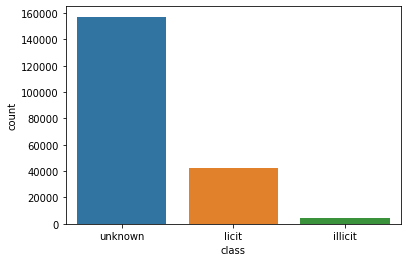

In [ ]:
sns.countplot(x=df_classes['class'])

In [ ]:
df_classes['class'].value_counts(dropna=False)

unknown    157205
licit       42019
illicit      4545
Name: class, dtype: int64

Text(0.5, 1.0, 'Number of transactions (licit/illicit) for timestep')

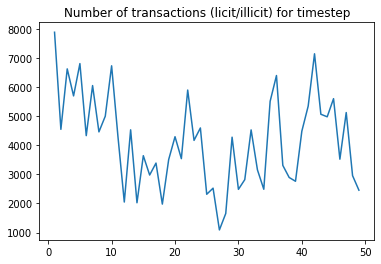

In [ ]:
df_features['time_step'].value_counts().sort_index().plot()
plt.title('Number of transactions (licit/illicit) for timestep')

In [ ]:
df_features_class = pd.merge(df_features, df_classes, left_on='id', right_on='txId', how='left')
df_features_class = df_features_class.drop(columns='txId')
df_features_class.head()

,id,time_step,trans_feat_0,trans_feat_1,trans_feat_2,trans_feat_3,trans_feat_4,trans_feat_5,trans_feat_6,trans_feat_7,...,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71,class
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,unknown
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,unknown
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792,unknown
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792,licit
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117,unknown


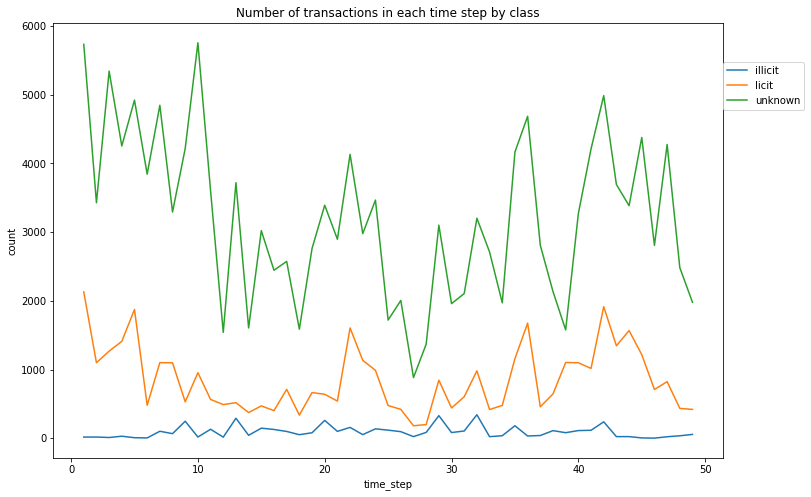

In [ ]:
plt.figure(figsize=(12, 8))
grouped = df_features_class.groupby(['time_step', 'class'])['id'].count().reset_index().rename(columns={'id': 'count'})
sns.lineplot(x='time_step', y='count', hue='class', data=grouped)
plt.legend(loc=(1.0, 0.8))
plt.title('Number of transactions in each time step by class')
plt.show()

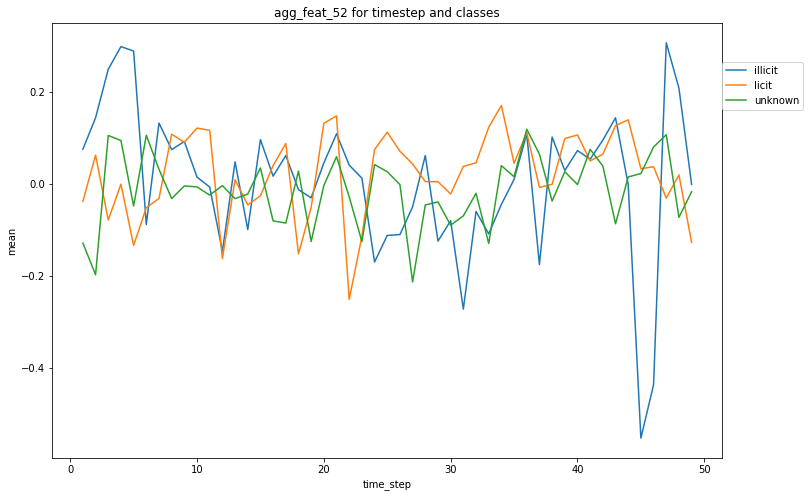

In [ ]:
plt.figure(figsize=(12, 8))
grouped = df_features_class.groupby(['time_step', 'class'])['agg_feat_52'].mean().reset_index().rename(columns={'agg_feat_52': 'mean'})
sns.lineplot(x='time_step', y='mean', hue='class', data=grouped);
plt.legend(loc=(1.0, 0.8))
plt.title('agg_feat_52 for timestep and classes')
plt.show()

In [ ]:
licit_mask = df_features_class['class'] == 'licit'
illicit_mask = df_features_class['class'] == 'illicit'
mask_known = licit_mask | illicit_mask
mask_known.sum()

46564

In [ ]:
df_known = df_features_class[mask_known].copy()
df_known = df_known.replace({'licit': 0, 'illicit': 1})
df_known.head()

,id,time_step,trans_feat_0,trans_feat_1,trans_feat_2,trans_feat_3,trans_feat_4,trans_feat_5,trans_feat_6,trans_feat_7,...,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71,class
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792,0
9,232029206,1,-0.005027,0.578941,-0.091383,4.380281,-0.063725,4.667146,0.851305,-0.163645,...,-0.613614,0.241128,0.241406,0.604120,0.008632,-0.131155,0.333211,-0.120613,-0.119792,0
10,232344069,1,-0.147852,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.137933,...,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,0
11,27553029,1,-0.151357,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.141519,...,-0.582077,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,0
16,3881097,1,-0.172306,-0.184668,-1.201369,0.028105,-0.043875,-0.029140,0.242712,-0.163640,...,-0.600999,0.241128,0.241406,0.018279,-0.068266,-0.084674,-0.054450,-1.760926,-1.760984,0


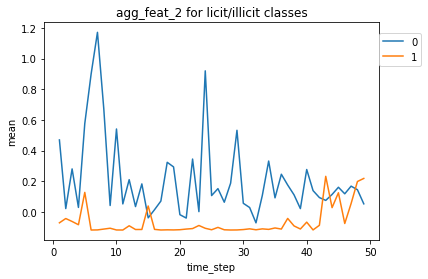

In [ ]:
g = df_known.groupby(['time_step', 'class'])['agg_feat_2'].mean().reset_index().rename(columns={'agg_feat_2': 'mean'})
sns.lineplot(x='time_step', y='mean', hue='class', data=g)
plt.legend(loc=(1.0, 0.8))
plt.title('agg_feat_2 for licit/illicit classes')
plt.show()

### Features selection

A Principal Component Analysis (PCA) is done, in order to get insight about how many features could be sufficient to explain all data.

In [ ]:
root_dataset_path = '/content/data/elliptic_bitcoin_dataset'
last_time_step = 49
last_train_time_step = 34
only_labeled = True

X_train_df, X_test_df, y_train, y_test = run_elliptic_preprocessing_pipeline(
    root_dataset_path=root_dataset_path,
    last_train_time_step=last_train_time_step,
    last_time_step=last_time_step,
   only_labeled=only_labeled)

In [ ]:
pca = PCA(n_components=166, whiten=True, random_state=0)

In [ ]:
pca.fit(X_train_df.values)
var = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
var  # cumulative sum of variance explained with [n] features

array([24.9, 38.7, 44.1, 49.1, 53.5, 57.3, 60.5, 62.7, 64.7, 66.6, 68.5,
       70.2, 71.8, 73.4, 74.8, 76.2, 77.5, 78.8, 80.1, 81.2, 82.2, 83.2,
       84.1, 84.9, 85.6, 86.3, 87. , 87.7, 88.3, 88.9, 89.5, 90. , 90.5,
       91. , 91.5, 92. , 92.4, 92.8, 93.2, 93.6, 94. , 94.4, 94.8, 95.1,
       95.4, 95.7, 96. , 96.3, 96.6, 96.8, 97. , 97.2, 97.4, 97.6, 97.8,
       98. , 98.2, 98.4, 98.5, 98.6, 98.7, 98.8, 98.9, 99. , 99.1, 99.2,
       99.3, 99.4, 99.5, 99.6, 99.7, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8,
       99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8,
       99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8,
       99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8,
       99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8,
       99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8,
       99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8,
       99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99

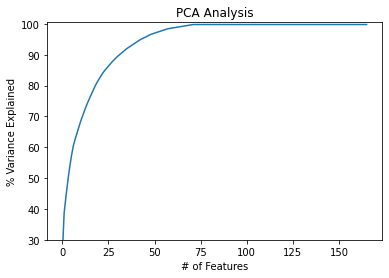

In [ ]:
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.ylim(30,100.5)
plt.style.context('seaborn-whitegrid')
plt.plot(var)

75 features could be sufficient to examplain more than 96% of data.

In [ ]:
import random 

# evaluation
from AML.evaluation.model_performance import *
from sklearn.metrics import precision_recall_curve, average_precision_score, precision_recall_fscore_support

def supervised_model_cv_fit_predict(X_train_df, y_train, X_test_df, model, runs=5):
    y_preds = []

    for i in range(runs):
        random.seed(i)
        model.fit(X_train_df, y_train)
        y_pred = model.predict(X_test_df)
        y_preds.append(y_pred)

    return y_preds
  
  
def plot_precision_recall_roc(y_test, y_probs):

    scores = {'avg_precision': [], 'best_f1': []}
    for y_prob in y_probs:
      precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
      f1_scores = 2*recall*precision/(recall+precision)
      #TODO: by removing nan f1-scores thresholds indexes are no more aligned
      f1_scores = f1_scores[~np.isnan(f1_scores)]
    
      best_threshold = thresholds[np.argmax(f1_scores)]
      display(Markdown(f'Best threshold: {best_threshold:.3f}'))
      best_f1_score = np.max(f1_scores)
      scores['best_f1'].append(best_f1_score)
      display(Markdown(f'Best F1-Score: {best_f1_score:.3f}'))

      average_precision = average_precision_score(y_test, y_prob)
      scores['avg_precision'].append(average_precision)
      display(Markdown(f'Average precision: {average_precision:.3f}'))
      display(Markdown(f'Percentage of true labels: {y_test.sum()/len(y_test):.3f}'))

      probas = np.column_stack((1 - y_prob, y_prob))
      skplt.metrics.plot_precision_recall(y_test, probas)
      plt.show()
      skplt.metrics.plot_roc(y_test, probas)
      plt.show()
    
    avg_precision = np.mean([score for score in scores['avg_precision']])
    avg_best_f1 = np.mean([score for score in scores['best_f1']])
    return avg_precision, avg_best_f1

def plot_confusion_matrix(y_true, y_preds, title=None, xtickslabels=None, ytickslabels=None):

    for y_pred in y_preds:
      precision, recall, f1score, support = precision_recall_fscore_support(y_true, y_pred)
      display(Markdown(f'Precision {precision}, recall {recall}, f1score {f1score}, support {support}'))    
    
      ax = skplt.metrics.plot_confusion_matrix(
          y_true,
          y_pred,
          normalize=True,
          figsize=(10, 8),
          title=title
         )
    
      if xtickslabels is not None:
        ax.set_xticklabels(xtickslabels)

      if ytickslabels is not None:
        ax.set_yticklabels(ytickslabels)
        
      plt.show()

## Supervision models

In [ ]:
X_train = X_train_df.values
X_test = X_test_df.values

In [ ]:
y_test.value_counts(dropna=False)

0    15587
1     1083
Name: class, dtype: int64

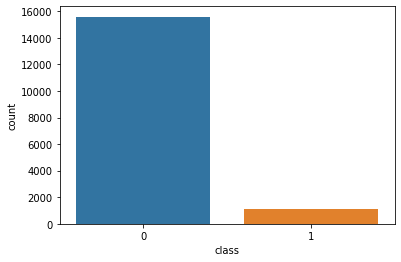

In [ ]:
sns.countplot(x=y_test)

**for each supervised classifier the precision recall curve, ROC curve and confusion matrix will be shown. Due to the nature of the problem (unbalanced dataset) the ROC curve is not the best choice (there are too few true positive), indeed the precision recall curve is able, in general, to better explain unbalanced dataset. However, both curves are shown, reporting separate curves for the two classes. The confusion matrix allows to get information about true positive and false positive.**

### Logistic Regression

In [ ]:
# clf = Supervised(
#     model='rf',
#     task='binary',
#     X_train=X_train,
#     y_train=y_train
# )

# rf_score = clf.train_cv()
# rf_score

In [ ]:
y_preds_lr = supervised_model_cv_fit_predict(X_train, y_train, X_test, LogisticRegression(max_iter=10000))


LR classifier

Best threshold: 1.000

Best F1-Score: 0.447

Average precision: 0.250

Percentage of true labels: 0.065

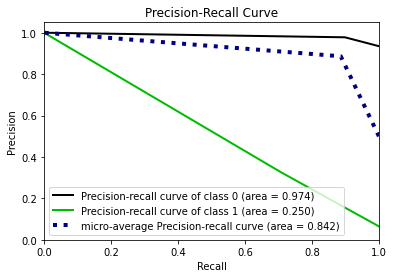

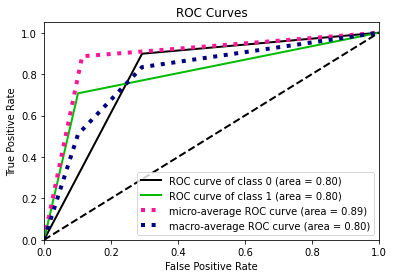

Best threshold: 1.000

Best F1-Score: 0.447

Average precision: 0.250

Percentage of true labels: 0.065

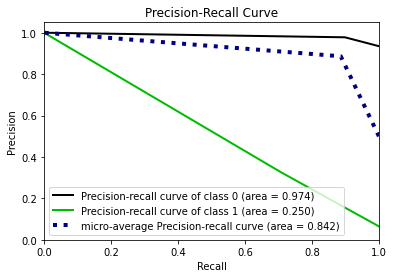

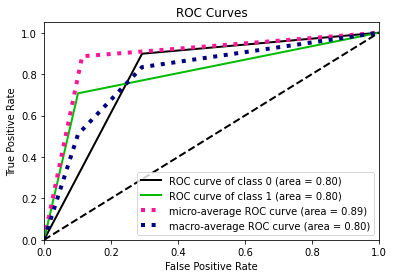

Best threshold: 1.000

Best F1-Score: 0.447

Average precision: 0.250

Percentage of true labels: 0.065

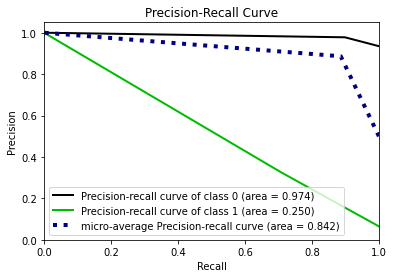

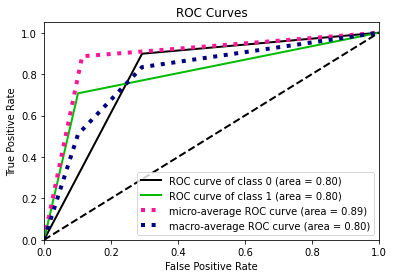

Best threshold: 1.000

Best F1-Score: 0.447

Average precision: 0.250

Percentage of true labels: 0.065

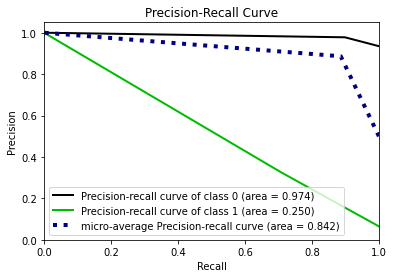

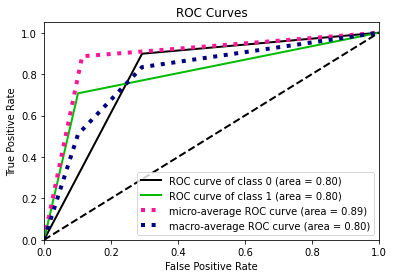

Best threshold: 1.000

Best F1-Score: 0.447

Average precision: 0.250

Percentage of true labels: 0.065

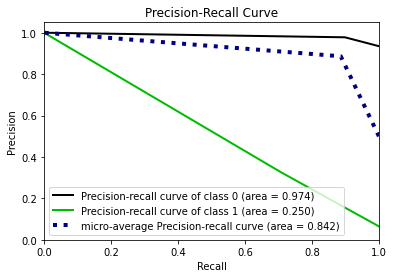

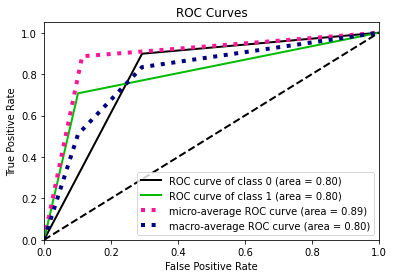

(0.2499572142210665, 0.44677748614756496)

In [ ]:
display(Markdown('LR classifier'))
plot_precision_recall_roc(y_test, y_preds_lr)

Precision [0.97786931 0.32651321], recall [0.89863348 0.70729455], f1score [0.93657852 0.44677749], support [15587  1083]

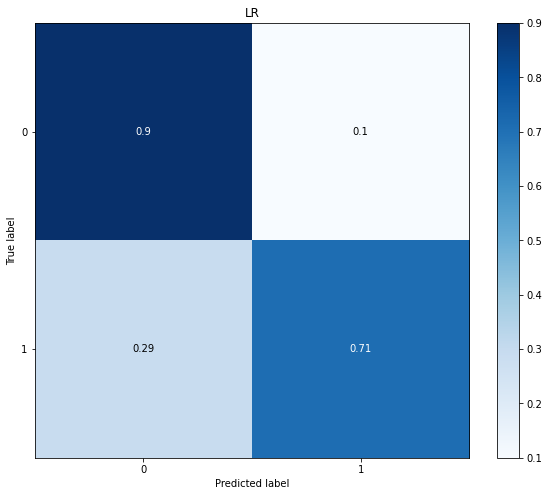

Precision [0.97786931 0.32651321], recall [0.89863348 0.70729455], f1score [0.93657852 0.44677749], support [15587  1083]

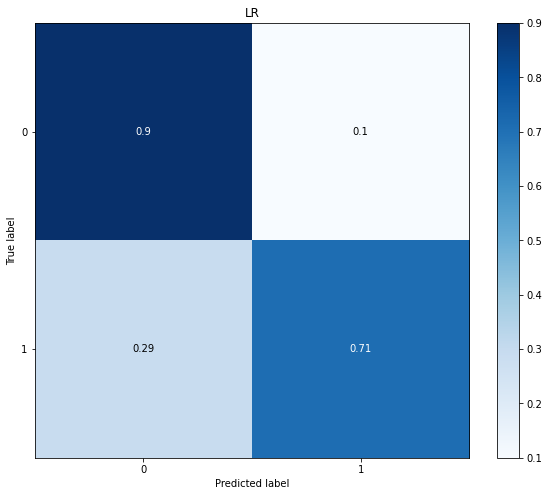

Precision [0.97786931 0.32651321], recall [0.89863348 0.70729455], f1score [0.93657852 0.44677749], support [15587  1083]

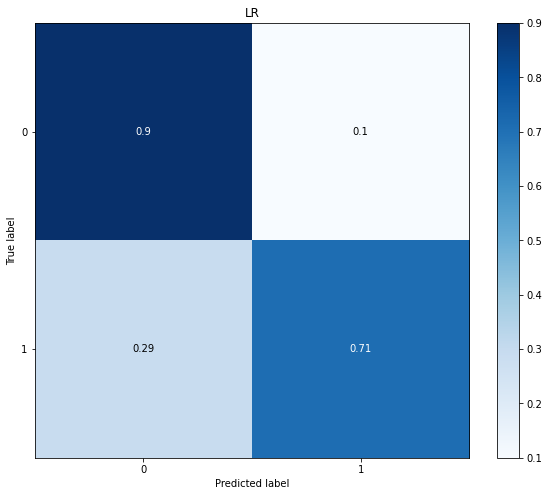

Precision [0.97786931 0.32651321], recall [0.89863348 0.70729455], f1score [0.93657852 0.44677749], support [15587  1083]

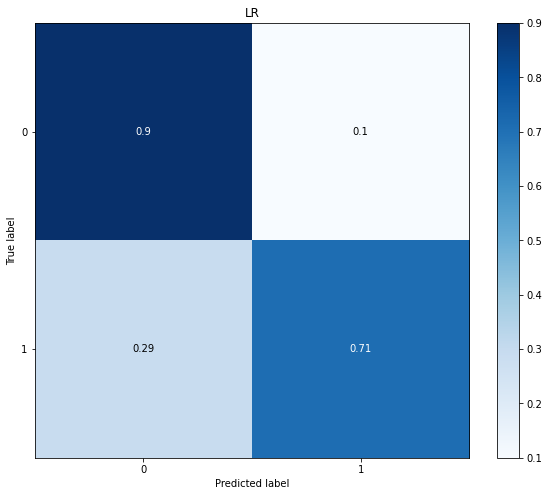

Precision [0.97786931 0.32651321], recall [0.89863348 0.70729455], f1score [0.93657852 0.44677749], support [15587  1083]

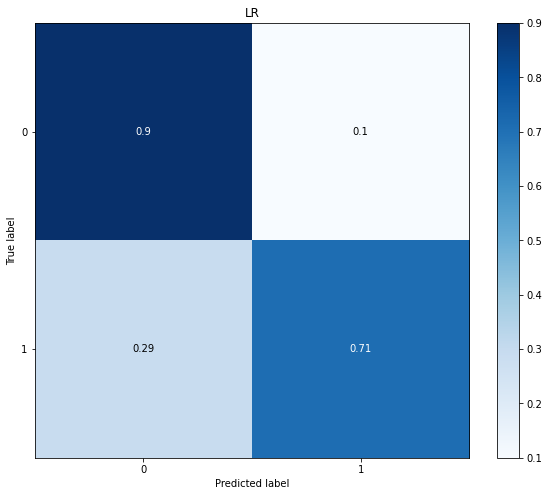

In [ ]:
plot_confusion_matrix(y_test, y_preds_lr, title='LR')

### XGBoost

In [ ]:
y_preds_xgboost = supervised_model_cv_fit_predict(X_train, y_train, X_test, XGBClassifier())

XGB classifier

Best threshold: 1.000

Best F1-Score: 0.761

Average precision: 0.601

Percentage of true labels: 0.065

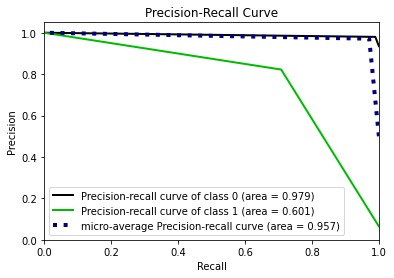

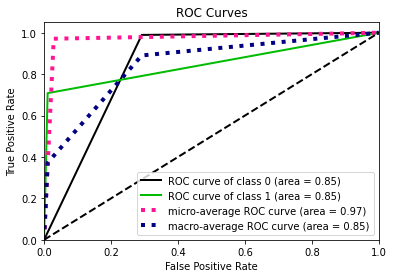

Best threshold: 1.000

Best F1-Score: 0.761

Average precision: 0.601

Percentage of true labels: 0.065

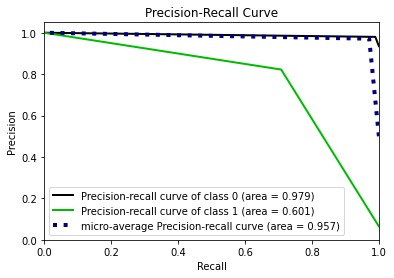

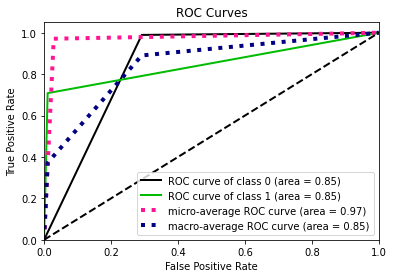

Best threshold: 1.000

Best F1-Score: 0.761

Average precision: 0.601

Percentage of true labels: 0.065

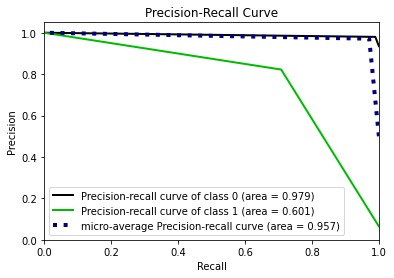

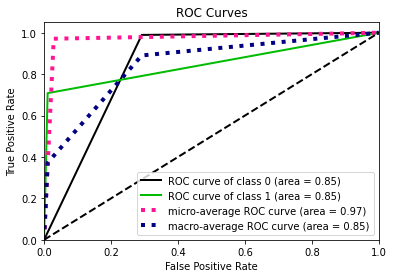

Best threshold: 1.000

Best F1-Score: 0.761

Average precision: 0.601

Percentage of true labels: 0.065

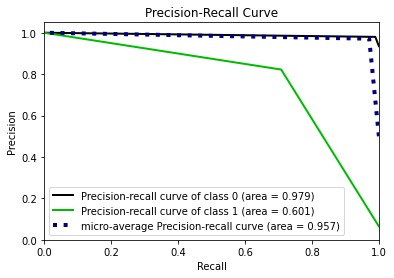

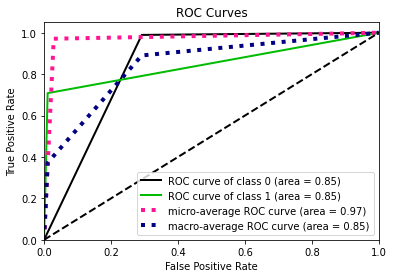

Best threshold: 1.000

Best F1-Score: 0.761

Average precision: 0.601

Percentage of true labels: 0.065

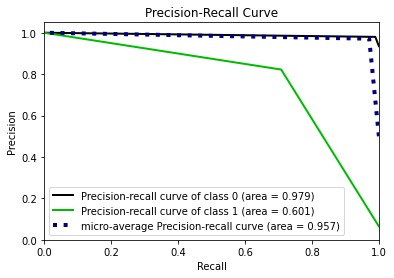

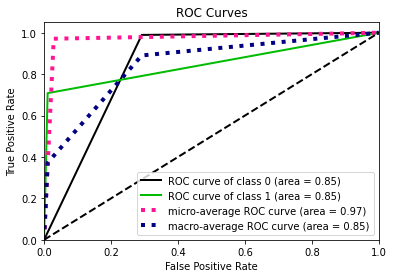

(0.6011675050364007, 0.7609126984126984)

In [ ]:
display(Markdown('XGB classifier'))
plot_precision_recall_roc(y_test, y_preds_xgboost)

Precision [0.97991993 0.82207931], recall [0.9893501  0.70821791], f1score [0.98461244 0.7609127 ], support [15587  1083]

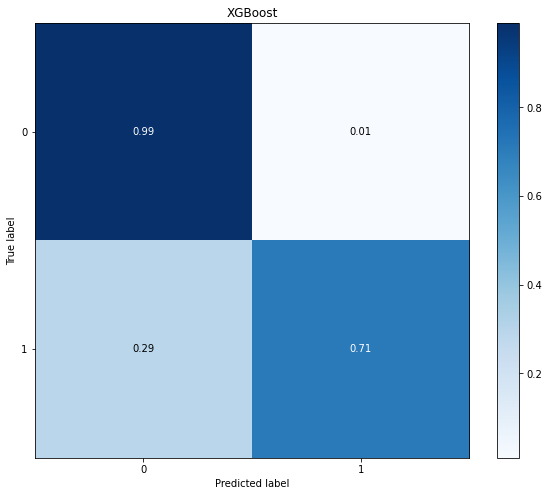

Precision [0.97991993 0.82207931], recall [0.9893501  0.70821791], f1score [0.98461244 0.7609127 ], support [15587  1083]

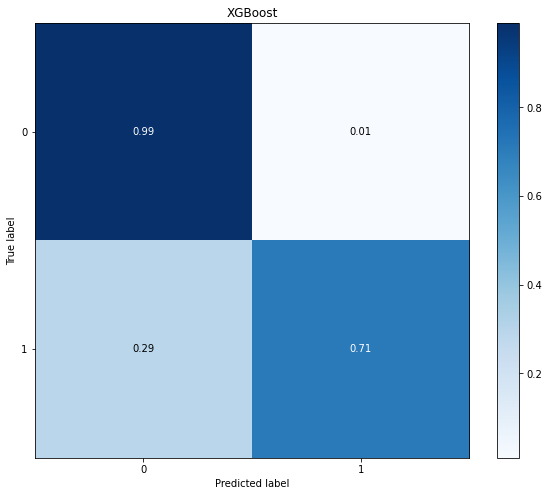

Precision [0.97991993 0.82207931], recall [0.9893501  0.70821791], f1score [0.98461244 0.7609127 ], support [15587  1083]

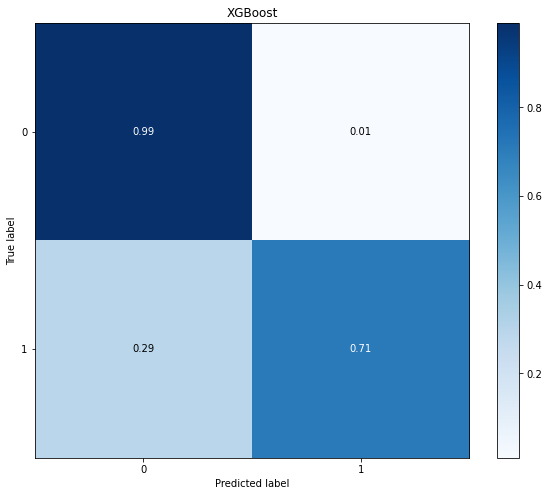

Precision [0.97991993 0.82207931], recall [0.9893501  0.70821791], f1score [0.98461244 0.7609127 ], support [15587  1083]

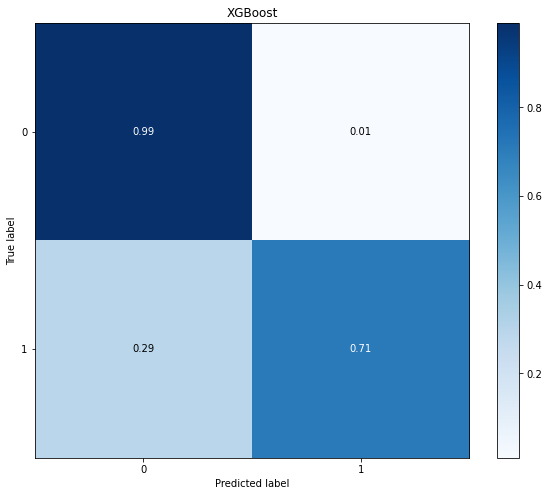

Precision [0.97991993 0.82207931], recall [0.9893501  0.70821791], f1score [0.98461244 0.7609127 ], support [15587  1083]

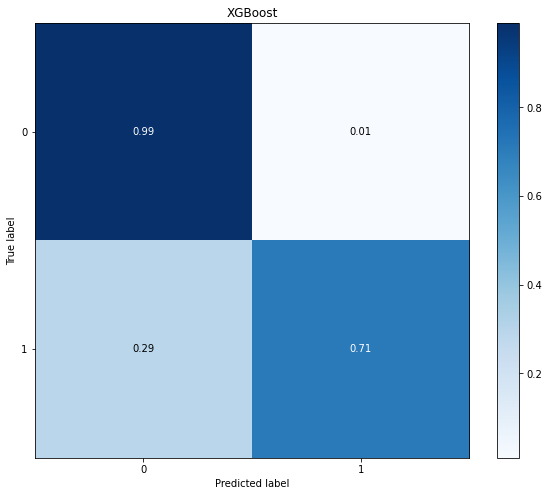

In [ ]:
plot_confusion_matrix(y_test, y_preds_xgboost, title='XGBoost')

### Random Forest

In [ ]:
y_preds_rf = supervised_model_cv_fit_predict(X_train, y_train, X_test, RandomForestClassifier())

'RF classifier'

Best threshold: 1.000

Best F1-Score: 0.828

Average precision: 0.719

Percentage of true labels: 0.065

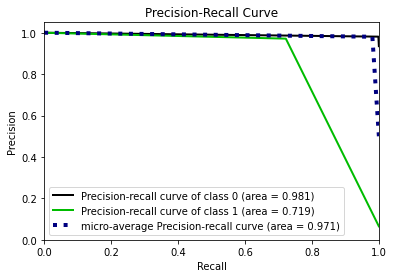

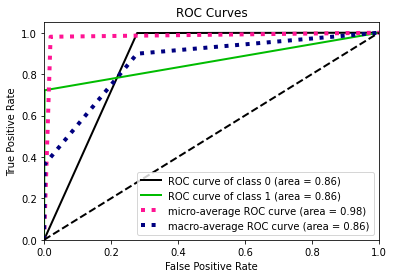

Best threshold: 1.000

Best F1-Score: 0.824

Average precision: 0.711

Percentage of true labels: 0.065

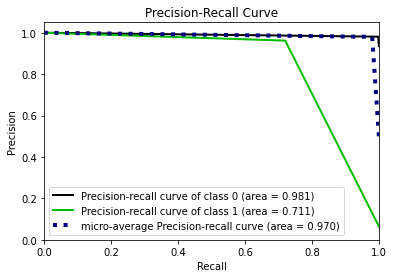

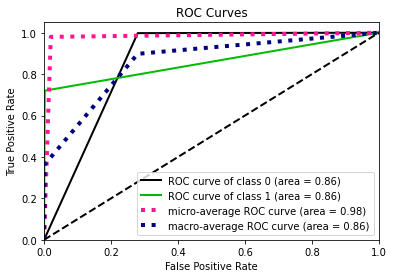

Best threshold: 1.000

Best F1-Score: 0.826

Average precision: 0.713

Percentage of true labels: 0.065

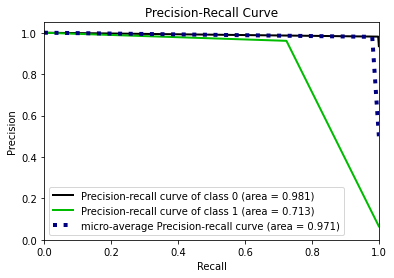

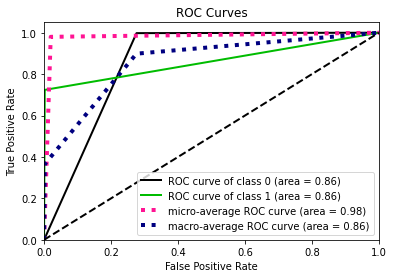

Best threshold: 1.000

Best F1-Score: 0.827

Average precision: 0.716

Percentage of true labels: 0.065

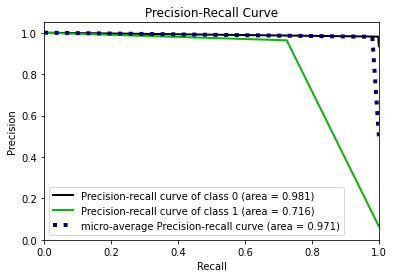

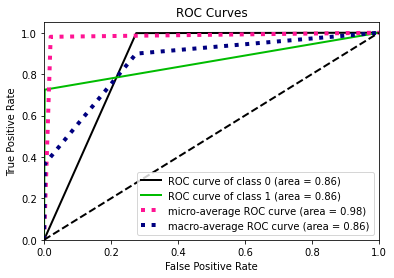

Best threshold: 1.000

Best F1-Score: 0.828

Average precision: 0.719

Percentage of true labels: 0.065

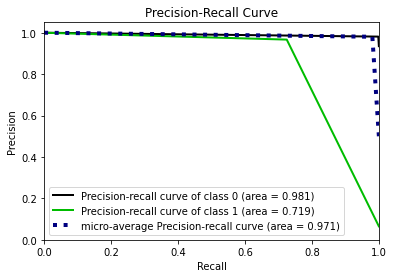

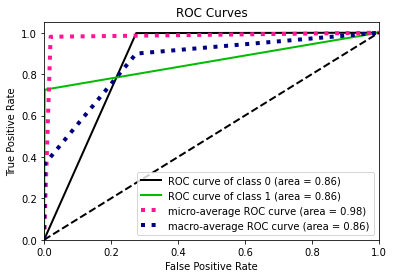

(0.7156942977437695, 0.8266847527153232)

In [ ]:
display('RF classifier')
plot_precision_recall_roc(y_test, y_preds_rf)

Precision [0.98102742 0.97142857], recall [0.99852441 0.72206833], f1score [0.98969859 0.82838983], support [15587  1083]

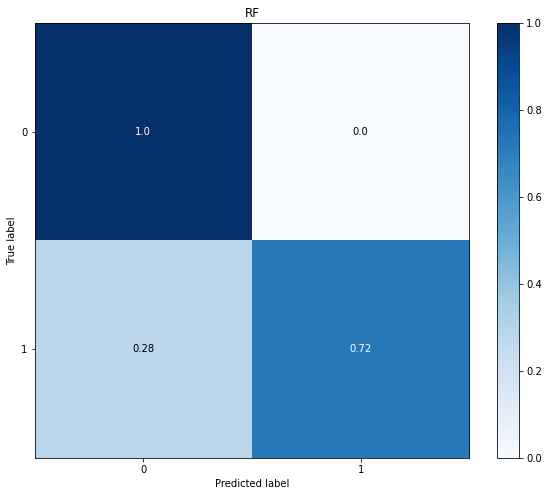

Precision [0.98089413 0.96177559], recall [0.99801116 0.72022161], f1score [0.98937862 0.82365364], support [15587  1083]

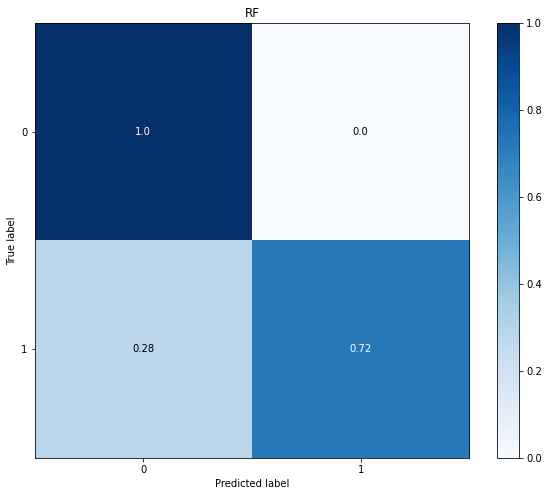

Precision [0.98114041 0.96078431], recall [0.99794701 0.72391505], f1score [0.98947235 0.82569774], support [15587  1083]

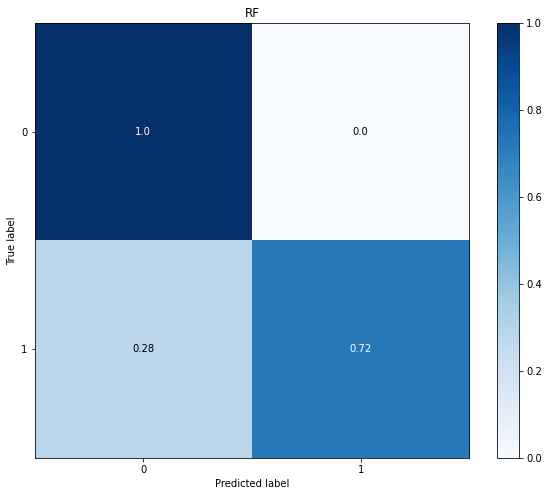

Precision [0.98120467 0.96319018], recall [0.99807532 0.72483841], f1score [0.98956809 0.82718651], support [15587  1083]

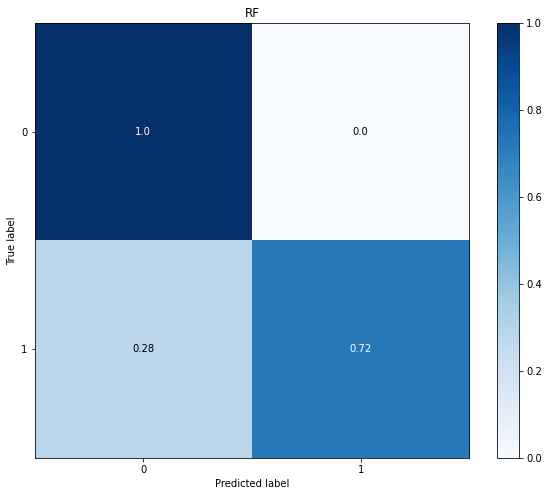

Precision [0.98120822 0.96674877], recall [0.99826779 0.72483841], f1score [0.98966449 0.82849604], support [15587  1083]

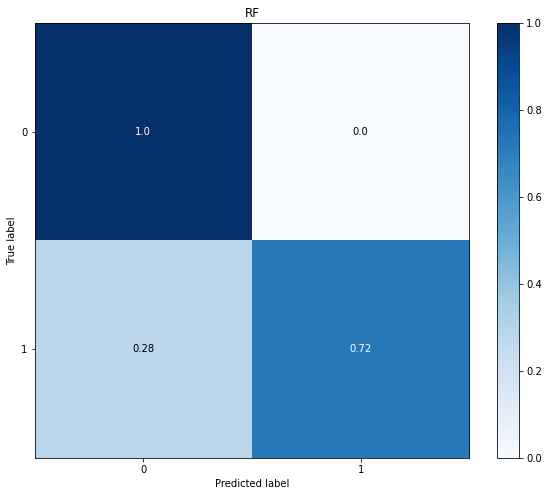

In [ ]:
plot_confusion_matrix(y_test, y_preds_rf, title='RF')

### LightGBM

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
from multiprocessing import cpu_count

from AML.evaluation.model_performance import *

n_cpu = cpu_count()

params = {
      'nthread': n_cpu,
      'objective': 'binary',
      'metric': 'cross-entropy',
      'learning_rate': 0.05,
      'num_leaves': 63,
      'min_data_in_leaf': 10,
      'feature_fraction': 0.8,
      'bagging_fraction': 0.8,
      'bagging_freq': 5,
      'reg_alpha': 1,
      'reg_lambda': 1,
      'verbose': 1,
      'verbose_eval': True,
    }

def train_model(X, y, weight, parameters, num_boost):
    logger.info(f'Training model: weight {weight}')
    logger.info(f'parameters {parameters}, num_boost {num_boost}')
    
    train_data = lgb.Dataset(X, label=y, weight=weight)
    model = lgb.train(parameters, train_data, num_boost_round=num_boost)
    logger.info(f'model trained: ')
    return model
  
def get_balanced_weights(labels):
    class_weight = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
    weights = labels.map(lambda x: class_weight[0] if x == False else class_weight[1])
    return weights

In [ ]:
model = train_model(X_train, y_train, get_balanced_weights(y_train), params, 5)

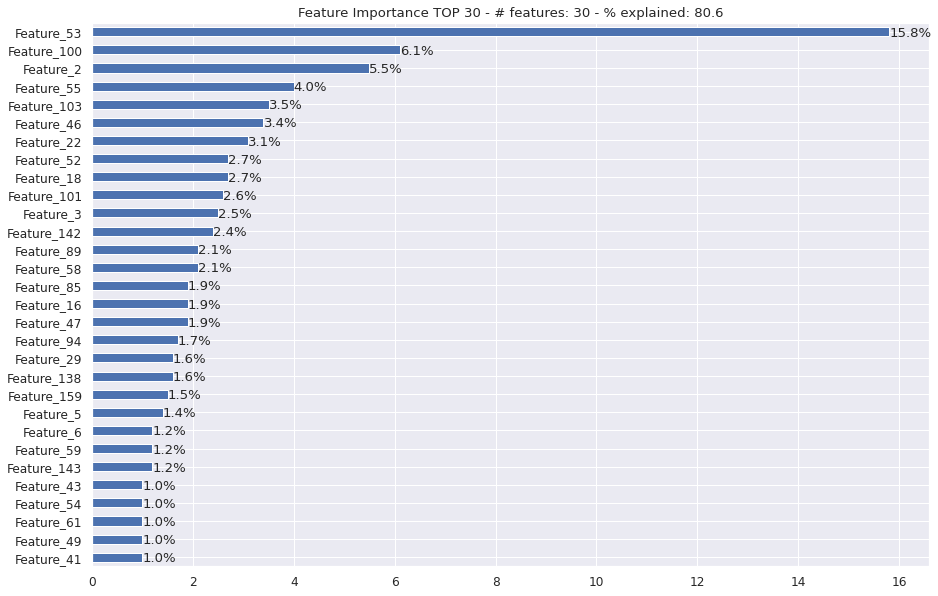

In [ ]:
SPLIT_WEIGHT = 0.6

importance_split = model.feature_importance(importance_type='split')
importance_gain = model.feature_importance(importance_type='gain')

importance = SPLIT_WEIGHT * importance_split / importance_split.sum() + \
             (1 - SPLIT_WEIGHT) * importance_gain / importance_gain.sum()

importance = pd.Series((100 * importance).round(decimals=1), index=model.feature_name())
importance = importance[importance > 0].dropna()
importance = importance.sort_values(ascending=False).iloc[:30]
importance = importance.sort_values()

# rename cols
importance.index = list(map(lambda x: 'Feature_' + x.split('_')[-1], importance.index.values))

with sns.axes_style('dark'):
    sns.set(font_scale=1.1)
    ax = importance.plot.barh(figsize=(15, 10), title=f'Feature Importance TOP 30 - # features: {len(importance)} - % explained: {importance.sum()}');

    for p in ax.patches:
        width = p.get_width()
        _ = ax.text(width, p.get_y(), f'{width}%')


In [ ]:
lgb_clf = lgb.sklearn.LGBMClassifier(n_jobs=n_cpu)
y_preds_lgb = supervised_model_cv_fit_predict(X_train_df, y_train, X_test, lgb_clf)

Precision [0.98109748 0.92018779], recall [0.99563739 0.72391505], f1score [0.98831396 0.81033592], support [15587  1083]

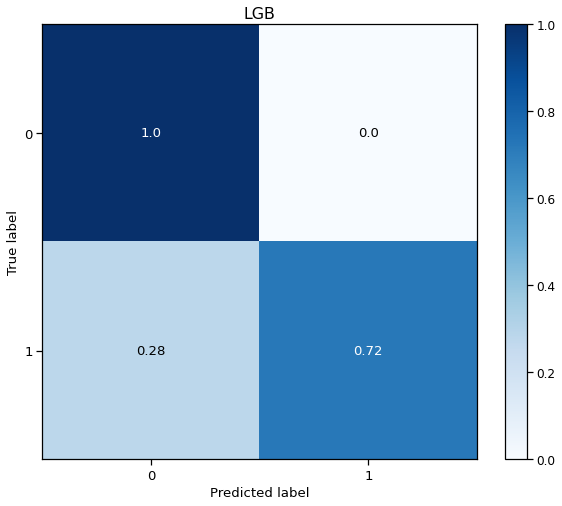

Precision [0.98109748 0.92018779], recall [0.99563739 0.72391505], f1score [0.98831396 0.81033592], support [15587  1083]

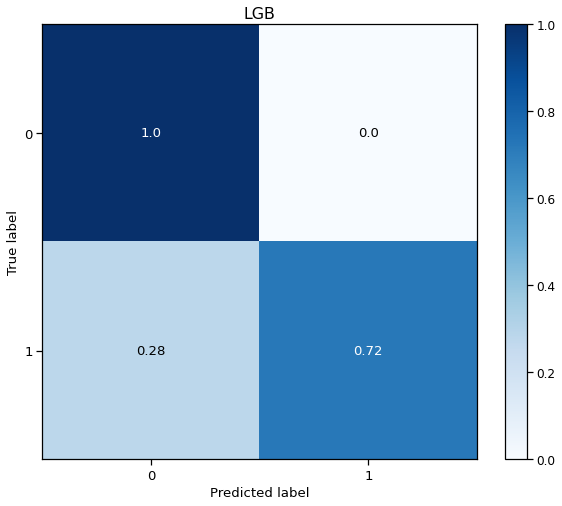

Precision [0.98109748 0.92018779], recall [0.99563739 0.72391505], f1score [0.98831396 0.81033592], support [15587  1083]

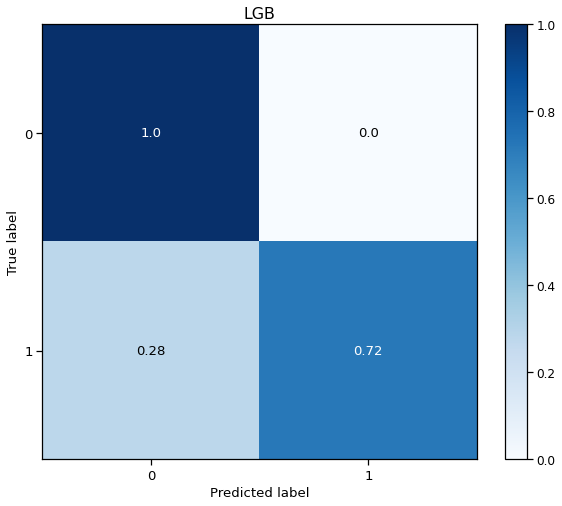

Precision [0.98109748 0.92018779], recall [0.99563739 0.72391505], f1score [0.98831396 0.81033592], support [15587  1083]

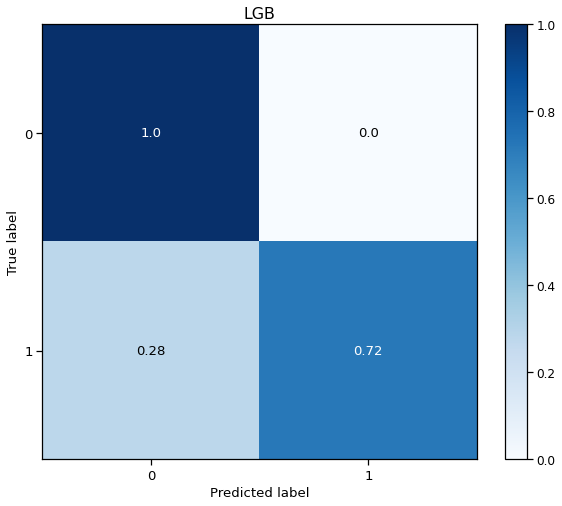

Precision [0.98109748 0.92018779], recall [0.99563739 0.72391505], f1score [0.98831396 0.81033592], support [15587  1083]

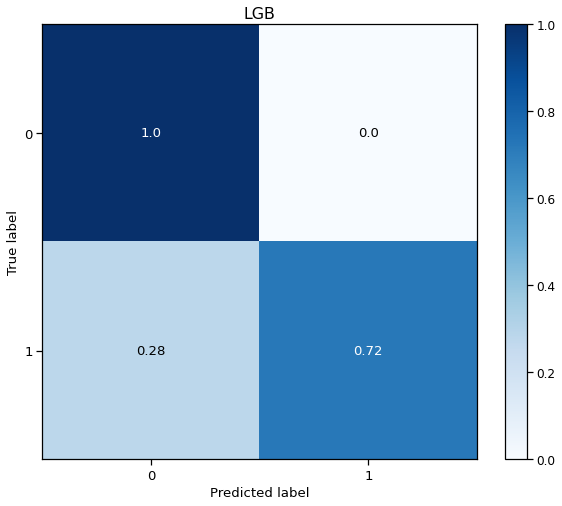

In [ ]:
plot_confusion_matrix(y_test, y_preds_lgb, title='LGB')

## Show aggregate results for timestemp
Now, aggregate results (for timestemp) are shown. The F1 score has beeen chosen as reference metric. F1 score is an harmonic mean between precision and recall, given equal importance to  them, avoiding to misunderstanding unbalanced dataset.

In [ ]:
from AML.evaluation.model_performance import calc_score_and_std_per_timestep

In [ ]:
avg_f1_lr_ts, _ = calc_score_and_std_per_timestep(X_test_df, y_test, y_preds_lr)
avg_f1_rf_ts, _ = calc_score_and_std_per_timestep(X_test_df, y_test, y_preds_rf)
avg_f1_xgboost, _ = calc_score_and_std_per_timestep(X_test_df, y_test, y_preds_xgboost)
avg_f1_lgb_ts, _ = calc_score_and_std_per_timestep(X_test_df, y_test, y_preds_lgb)
model_f1_ts_dict = {'LR': avg_f1_lr_ts,
                    'XGB': avg_f1_xgboost, 
                    'Random Forest': avg_f1_rf_ts, 
                    'LightGBM': avg_f1_lgb_ts}

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

In [ ]:
model_f1_ts_dict['LR']

array([0.71367521, 0.24299065, 0.45901639, 0.56707317, 0.54752852,
       0.51034483, 0.55214724, 0.69026549, 0.02247191, 0.03053435,
       0.01290323, 0.03571429, 0.03225806, 0.34615385, 0.06818182])

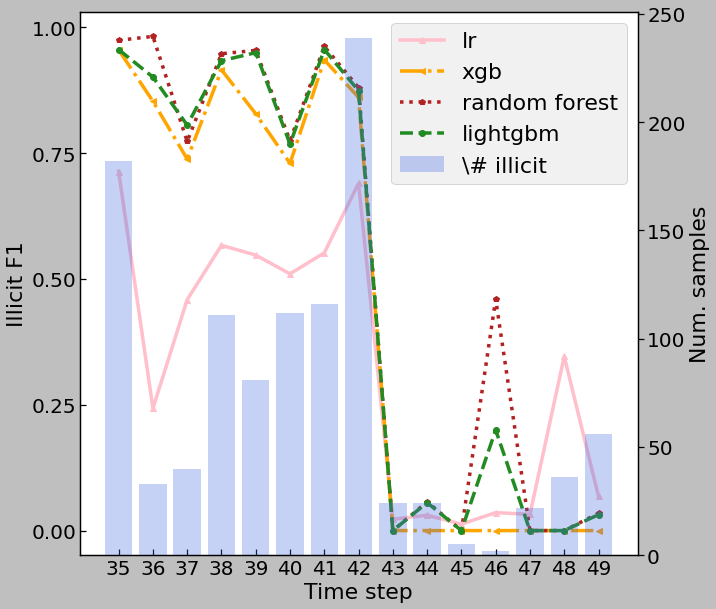

In [ ]:
from AML.evaluation.plot_evaluation import plot_performance_per_timestep

plot_performance_per_timestep(root_dataset_path=root_dataset_path, model_metric_dict=model_f1_ts_dict, last_train_time_step=last_train_time_step,
                              last_time_step=last_time_step, linewidth=3.5, figsize=(10, 10), labelsize=20, fontsize=22,
                              linestyles=['solid', "dashdot", 'dotted', 'dashed'], linecolor=['pink', 'orange', 'firebrick', 'forestgreen'],
                              barcolor='royalblue', baralpha=0.3)

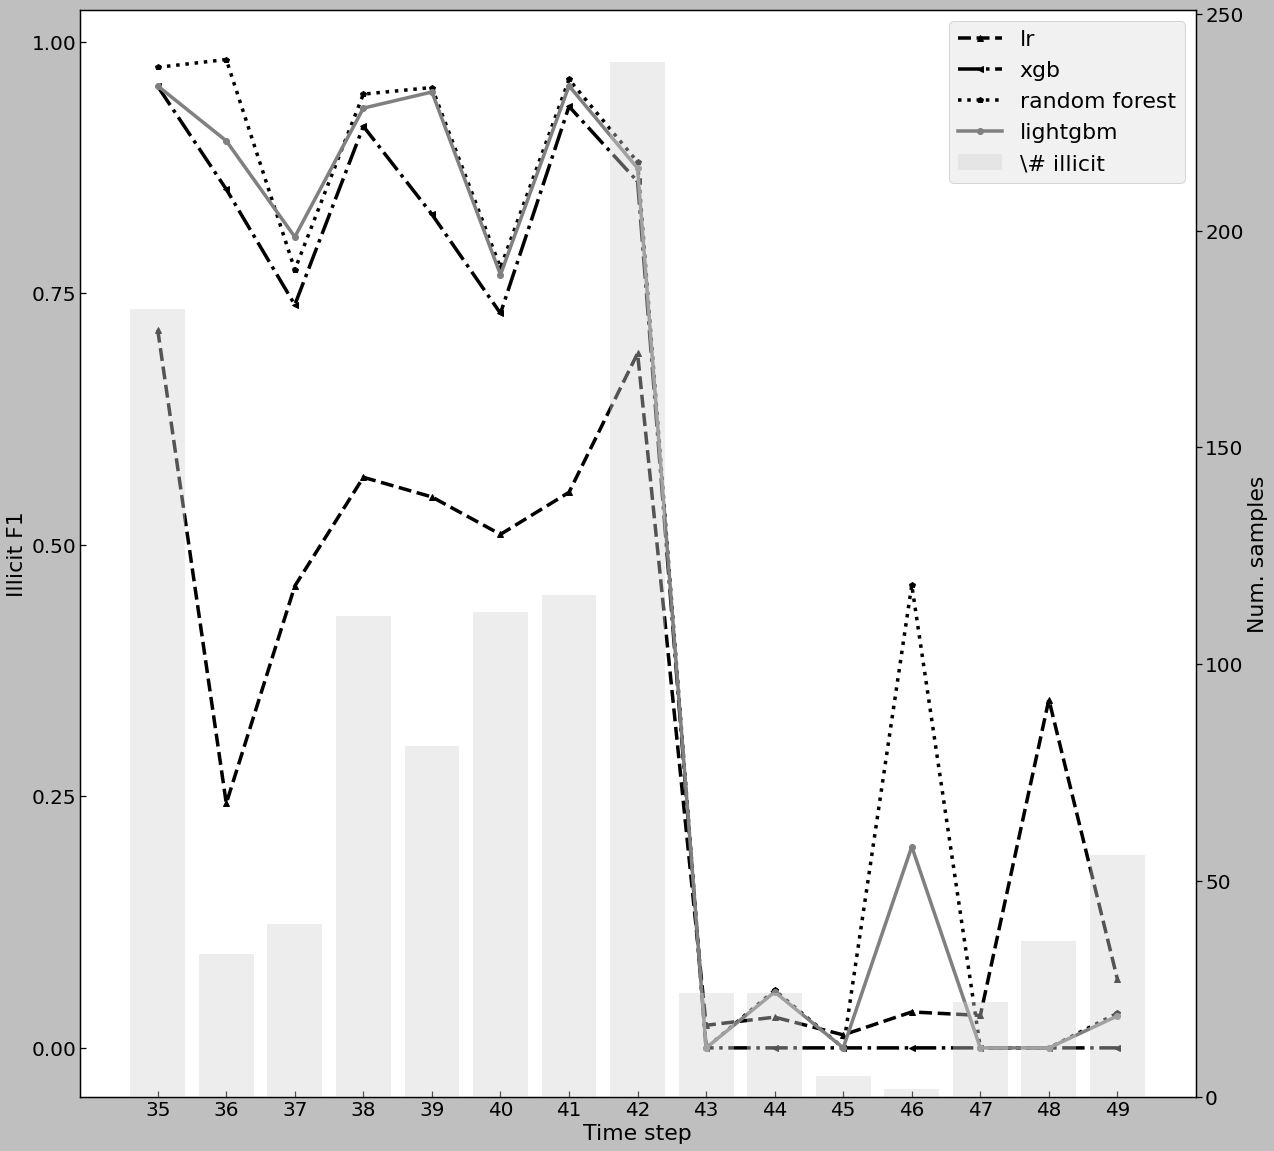

In [ ]:
from AML.evaluation.plot_evaluation import plot_performance_per_timestep

plot_performance_per_timestep(root_dataset_path=root_dataset_path, model_metric_dict=model_f1_ts_dict, last_train_time_step=last_train_time_step,
                              last_time_step=last_time_step, linewidth=3.5, figsize=(20, 20), labelsize=20, fontsize=22,
                              linestyles=['dashed', "dashdot", 'dotted', 'solid'], linecolor=['black', 'black', 'black', 'gray'],
                              barcolor='lightgray', baralpha=0.4)

LightGBM and Random Forest reach the best results (F1 score) acting in similar way. 

## Error Analysis

### How does agg_feat_52 (importance 15%) behave for the false positive transactions?

In [ ]:
mask_rf_fp = ~y_test & y_preds_rf[0]
idx_fp_rf = mask_rf_fp[mask_rf_fp == 1].index
mask_lgb_fp = ~y_test & y_preds_lgb[0]
idx_fp_lgb = mask_rf_fp[mask_lgb_fp == 1].index
mask_rf_fp.sum(), mask_lgb_fp.sum()

(23, 68)

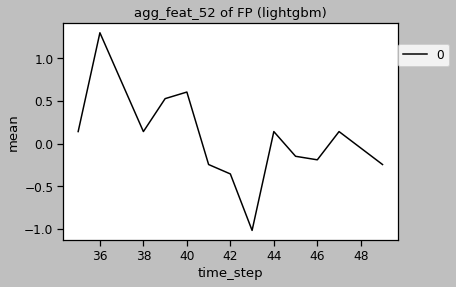

In [ ]:
g = df_known.iloc[idx_fp_lgb].groupby(['time_step', 'class'])['agg_feat_52'].mean().reset_index().rename(columns={'agg_feat_52': 'mean'})
sns.lineplot(x='time_step', y='mean', hue='class', data=g)
plt.legend(loc=(1.0, 0.8))
plt.title('agg_feat_52 of FP (lightgbm)')
plt.show()

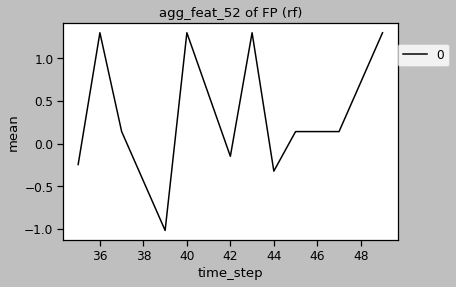

In [ ]:
g = df_known.iloc[idx_fp_rf].groupby(['time_step', 'class'])['agg_feat_52'].mean().reset_index().rename(columns={'agg_feat_52': 'mean'})
sns.lineplot(x='time_step', y='mean', hue='class', data=g)
plt.legend(loc=(1.0, 0.8))
plt.title('agg_feat_52 of FP (rf)')
plt.show()

### How does agg_feat_52 (importance 15%) behave for the false negative transactions?

In [ ]:
mask_rf_fn = y_test & ~y_preds_rf[0]
idx_fn_rf = mask_rf_fp[mask_rf_fn == 1].index
mask_lgb_fn = y_test & ~y_preds_lgb[0]
idx_fn_lgb = mask_rf_fp[mask_lgb_fn == 1].index
mask_rf_fn.sum(), mask_lgb_fn.sum()

(301, 299)

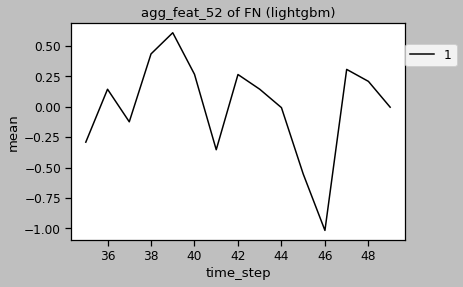

In [ ]:
g = df_known.iloc[idx_fn_lgb].groupby(['time_step', 'class'])['agg_feat_52'].mean().reset_index().rename(columns={'agg_feat_52': 'mean'})
sns.lineplot(x='time_step', y='mean', hue='class', data=g)
plt.legend(loc=(1.0, 0.8))
plt.title('agg_feat_52 of FN (lightgbm)')
plt.show()

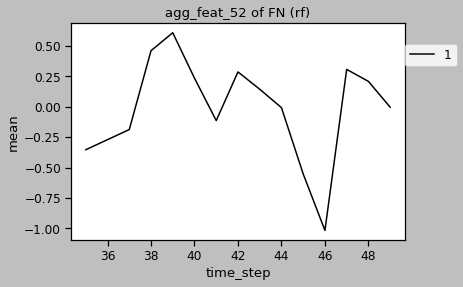

In [ ]:
g = df_known.iloc[idx_fn_rf].groupby(['time_step', 'class'])['agg_feat_52'].mean().reset_index().rename(columns={'agg_feat_52': 'mean'})
sns.lineplot(x='time_step', y='mean', hue='class', data=g)
plt.legend(loc=(1.0, 0.8))
plt.title('agg_feat_52 of FN (rf)')
plt.show()

# Report analysis

In [ ]:
#my_report = sv.analyze(df_features_class)
#my_report.show_html('./SWEETVIZ_REPORT.html')